## Intro

The webpage we have selected from the forums is titled 'Chronic Car Buyers Anonymous,' accessible at https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous. This group consists of individuals who frequently go car shopping and share their thoughts about various cars. Analyzing the discussions and preferences of this group provides valuable insights into consumer trends and preferences, which can significantly benefit automotive businesses in tailoring their marketing strategies and product development.

## 1. Data Scraping

In [1]:
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

entries = []
entry = []
urlnumber = 2 # Give the page number to start with


while urlnumber < 150: # Give the page number to end with

    url = 'https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

## 2. Data Pre-processing
The goal of this part is to 1) extract unique brand names from each comment, and 2) tokenize the comments so that further insights can be generated based on the key attributes mentioned. The output is a cleansed dataframe, which everyone can use to perform analytics based on their use cases. Additionally, the output is also saved as an Excel file for those who would like to review it firsthand.

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

Loading the brands and models, clean up and change to lowercase; Creating a dictionary to store them in key value pairs

In [3]:
# Define a function to clean the text
def clean_text(text):
    # Replace or remove unwanted characters here
    text = text.replace(',', '').replace('.', '')
    return text.strip().lower()

# Read the csv file into a dataframe
brand_model_data = pd.read_csv('models.csv', header=None)
brand_model_data.columns = ['Brand', 'Model']

# Remove the row where the Brand is 'car'
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'car']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'seat']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'problem']

# Ensure the columns are named correctly
brand_model_data.columns = ['Brand', 'Model']

# Creating a dictionary with the brand as key and a list of unique models as value
brand_model_dict = {}
for index, row in brand_model_data.iterrows():
    # Apply cleaning function to brand and model
    brand = clean_text(row['Brand'])
    model = clean_text(row['Model'])

    if brand in brand_model_dict:
        # Add the model to the brand's list if it's not already there
        if model not in brand_model_dict[brand]:
            brand_model_dict[brand].append(model)
    else:
        brand_model_dict[brand] = [model]

# Formatting the output for better readability with all models
for brand, models in brand_model_dict.items():
    models_list = ", ".join(models)
    print(f"{brand}: {models_list}")

acura: integra, legend, vigor, rlx, ilx, mdx, rdx, tsx, rsx
audi: quattro, a4, a6, a5, a7, q3, q5, q7, a8, a3
bmw: 3-series, 5-series, 6-series, 4-series, xdrive, alpina, 330ci, 328i, 330c, 335i, 335d, 528i, 535i, 128i, 640i, 3er, 5er, m5, m3, m6, bmws, bmwesque
buick: park avenue, la crosse, lacrosse, century, enclave, encore, regal, buicks
cadillac: escalade, srx, xts
chevrolet: grand blazer, trailblazer, silverado, colorado, corvette, suburban, cavalier, caprice, captiva, equinox, express, lacetti, montana, uplander, orlando, tornado, tracker, traverse, camaro, cobalt, impala, lumina, malibu, prisma, tavera, agile, celta, cruze, lanos, omega, optra, sonic, spark, tahoe, aveo, lova, n200, niva, onix, s-10, sail, volt, chevy, malibus
chrysler: town and country, chrysler 300, chrysler 200, pacifica, cruiser, sebring, 300m, lx, chryslers
dodge: challenger, intrepid, avenger, charger, durango, journey, caliber, stealth, magnum, viper, dart, ram
ford: crownvictoria, expedition, supervan, 

Change the comments to lowercase, and replace the models with brand names where neccessary

In [4]:
# Function to replace model names with brand names in a comment
def replace_models_with_brands(comment, brand_model_dict):
    for brand, models in brand_model_dict.items():
        for model in models:
            if model in comment:
                comment = comment.replace(model, brand)
    return comment

# Function to list unique occurrences of brand names in a comment
def list_unique_brands(comment, brand_model_dict):
    unique_brands = set()
    for brand in brand_model_dict.keys():
        if brand in comment:
            unique_brands.add(brand)
    return ", ".join(unique_brands)

# Load the comments data file
forum_data = pd.read_csv('edmunds_extraction.csv', header=None)

# Clean and lowercase all text in the comments
forum_data.iloc[:, 2] = forum_data.iloc[:, 2].apply(clean_text)

# Apply the function to replace models with brands in each comment
forum_data['Processed Text'] = forum_data.iloc[:, 2].apply(lambda comment: replace_models_with_brands(comment, brand_model_dict))

# Apply the function to list unique brands in each comment
forum_data['Brands Mentioned'] = forum_data['Processed Text'].apply(lambda comment: list_unique_brands(comment, brand_model_dict))

# Display the processed data
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda"
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet


Count the Top 10 Popular Cars

In [5]:
from collections import Counter
import pandas as pd

# Combine all brand names into a single list
all_brands = []
for brands in forum_data['Brands Mentioned']:
    # Split the brands and add to the list, skipping empty entries
    all_brands.extend([brand for brand in brands.split(', ') if brand])

# Count the occurrences of each brand
brand_counts = Counter(all_brands)

# Convert the counter to a DataFrame for better readability
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Occurrences'])

# Sort the DataFrame by occurrences in descending order
brand_counts_df = brand_counts_df.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(brand_counts_df)

         Brand  Occurrences
0       toyota         2104
1        honda         1799
2         ford          741
3       nissan          724
4        dodge          657
5          bmw          640
6    chevrolet          563
7        acura          437
8       subaru          397
9   volkswagen          376
10    chrysler          353
11       mazda          301
12        audi          277
13     pontiac          271
14     hyundai          269
15      saturn          251
16       volvo          248
17       sedan          211
18        mini          191
19    mercedes          188
20     lincoln           77
21    cadillac           61
22     mercury           54
23       buick           51
24    infiniti           39
25         kia           35
26      suzuki           26
27  mitsubishi           25


In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string
from nltk.corpus import wordnet

brand_list=set(brand_counts_df["Brand"])

# Step 1: Remove Car Brands
def remove_brands(text, brand_list):
    for brand in brand_list:
        text = text.replace(brand, "")
    return text

# Step 2: Lemmatize Function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Step 3: Remove Stop Words and Punctuation, and Filter Single Letters
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())
punctuation = set(string.punctuation)

def filter_words(words):
    unique_words = set()  # Initialize an empty set to store unique words
    for word in words:
        if (word not in stop_words 
            and word not in punctuation
            and word not in ["''", "``", "--"]
            and len(word) > 1 
            and not re.search("(n't|'s|'m|'ve|'d|'ll|'re)$", word)
            and not re.fullmatch(r"\.{2,}", word)):
            unique_words.add(word)
    return list(unique_words)


# Step 4: Process and Add to DataFrame
forum_data['Words List'] = forum_data['Processed Text'].apply(lambda x: remove_brands(x, brand_list))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: lemmatize_text(x))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: filter_words(x))

In [7]:
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[choice, love, coupe, power, traffic, 30mpg, 2..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[turn, 2k, 4-spd, automatic, 373, highway, 15,..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[78, coolant, turn, gauge, 70, road, rod, tie,..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet,"[school, gauge, package, speedometer, gas, opt..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[relive, 78, turn, car, friend, sell, enjoy, m..."


In [8]:
attribute_counts = pd.Series([attribute for sublist in forum_data['Words List'] for attribute in sublist]).value_counts()
print(attribute_counts)

car                       3076
drive                     1633
year                      1564
good                      1543
buy                       1529
                          ... 
manley                       1
althouh                      1
interestcoincidentally       1
30kstopped                   1
storeof                      1
Length: 25798, dtype: int64


In [9]:
attributes_df = attribute_counts.reset_index()
attributes_df.columns = ['Attribute', 'Count']

In [10]:
attributes_df.head(200)

,Attribute,Count
0,car,3076
1,drive,1633
2,year,1564
3,good,1543
4,buy,1529
5,time,1110
6,mile,1009
7,thing,923
8,nice,840
9,lot,818


In [11]:
#forum_data.to_excel("after_extracted_make.xlsx")

## 3. Analysis

### Task A

### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task. Show the brands on a multi-dimensional scaling (MDS) map.

Top 10 Brands Selected

In [12]:
# Identify top 10 brands by frequency
all_brands = []
for brands in forum_data['Brands Mentioned']:
    all_brands.extend([brand for brand in brands.split(', ') if brand])
brand_counts = Counter(all_brands)
top_10_brands = [brand for brand, count in brand_counts.most_common(10)]

In [13]:
top_10_brands

['toyota',
 'honda',
 'ford',
 'nissan',
 'dodge',
 'bmw',
 'chevrolet',
 'acura',
 'subaru',
 'volkswagen']

Calculate the lift ratio and generate the MDS map

Lift Ratios between Brand Pairs:
      Brand 1     Brand 2  Lift Ratio
0      nissan       dodge    2.535802
1        ford   chevrolet    2.341419
2       honda       acura    2.296725
3      subaru  volkswagen    2.181253
4        ford       dodge    2.097622
5       dodge   chevrolet    2.000589
6        ford  volkswagen    1.991989
7   chevrolet      subaru    1.887155
8      nissan   chevrolet    1.797297
9        ford      nissan    1.793157
10      acura      subaru    1.791468
11  chevrolet  volkswagen    1.677941
12        bmw       acura    1.666905
13        bmw  volkswagen    1.660572
14     toyota       dodge    1.595280
15     toyota      nissan    1.583671
16     toyota   chevrolet    1.574266
17     nissan  volkswagen    1.549459
18       ford      subaru    1.534450
19      honda      subaru    1.533458
20      honda      nissan    1.499912
21     toyota        ford    1.495128
22     toyota      subaru    1.488349
23     toyota  volkswagen    1.440519
24      acura  vo

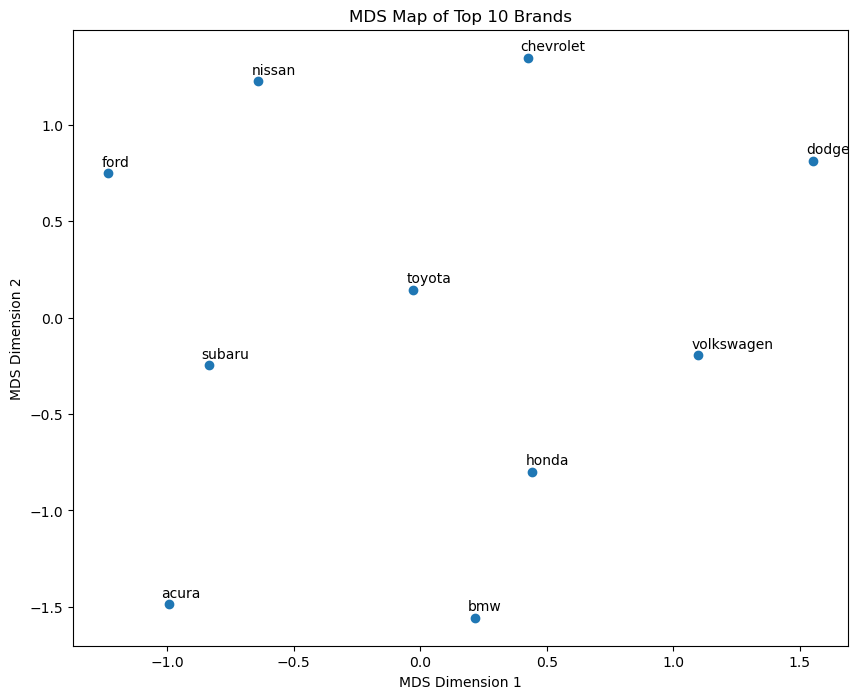

In [14]:
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculate Lift Ratios
def calculate_lift(brand1, brand2, data):
    total_posts = len(data)
    brand1_count = sum(brand1 in brands for brands in data['Brands Mentioned'])
    brand2_count = sum(brand2 in brands for brands in data['Brands Mentioned'])
    both_count = sum(brand1 in brands and brand2 in brands for brands in data['Brands Mentioned'])
    return (total_posts * both_count) / (brand1_count * brand2_count) if brand1_count and brand2_count else 0

lift_matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
lift_ratios = []

# Only calculate lift for unique brand pairs
for i, brand1 in enumerate(top_10_brands):
    for brand2 in top_10_brands[i+1:]:
        lift = calculate_lift(brand1, brand2, forum_data)
        lift_matrix.loc[brand1, brand2] = lift
        lift_matrix.loc[brand2, brand1] = lift  # Symmetric
        lift_ratios.append((brand1, brand2, lift))

# Create a DataFrame for lift ratios
lift_df = pd.DataFrame(lift_ratios, columns=['Brand 1', 'Brand 2', 'Lift Ratio'])
lift_df = lift_df.sort_values(by='Lift Ratio', ascending=False).reset_index(drop=True)

# Display the DataFrame of lift ratios
print("Lift Ratios between Brand Pairs:")
print(lift_df)

# Replace NaN values in the lift matrix with 1 (indicating no lift)
lift_matrix = lift_matrix.fillna(1)

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=0)
mds_coords = mds.fit_transform(lift_matrix)

# Plot MDS map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], marker='o')
for label, x, y in zip(top_10_brands, mds_coords[:, 0], mds_coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-5, 5), textcoords='offset points')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Map of Top 10 Brands')
plt.show()

**Task C: What are the 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands?**

After analyzing the words from the attributes dataframe, we are using the following words:
1. Seat
2. mileage
3. tire (and wheels)
4. engine (and power)
5. interior

In [15]:
#Replace 'wheels' with 'tire' and 'power' with 'engine' in the dataset
forum_data.replace({'wheels': 'tire', 'power': 'engine'}, regex=True, inplace=True)

In [16]:
# Sorting the DataFrame by count in descending order and getting the top 5 rows
top_5_brands = brand_counts_df.head(5)

# Displaying the result
print(top_5_brands)

top_5_attributes = ['seat', 'mileage', 'tire', 'engine', 'interior']

    Brand  Occurrences
0  toyota         2104
1   honda         1799
2    ford          741
3  nissan          724
4   dodge          657


In [17]:
# Function to calculate lift
def calculate_lift(forum_data, brand, attribute):
    total_comments = len(forum_data)

    # Count how many times the brand appears
    count_brand = sum(brand in comment for comment in forum_data['Brands Mentioned'])

    # Count how many times the attribute appears
    count_attribute = sum(attribute in comment for comment in forum_data['Processed Text'])

    # Count how many times both the brand and attribute appear together
    count_both = sum(brand in brand_mention and attribute in processed_text 
                     for brand_mention, processed_text in zip(forum_data['Brands Mentioned'], forum_data['Processed Text']))

    # Calculate probabilities
    p_brand = count_brand / total_comments
    p_attribute = count_attribute / total_comments
    p_both = count_both / total_comments

    # Calculate lift
    if p_brand * p_attribute == 0:  # Prevent division by zero
        return 0
    else:
        return p_both / (p_brand * p_attribute)


# Extracting the top 5 brand names from the DataFrame
top_5_brands = brand_counts_df['Brand'].head(5).tolist()

# Top 5 attributes
top_5_attributes = ['seat', 'mileage', 'tire', 'engine', 'interior']

# Function to calculate lift remains the same

# Calculating lift for each pair using brand names
lift_values_with_names = {}
for brand in top_5_brands:
    for attribute in top_5_attributes:
        lift_values_with_names[(brand, attribute)] = calculate_lift(forum_data, brand, attribute)

# Displaying the lift values with brand names
lift_values_with_names

# Convert the lift values dictionary into a DataFrame with an additional step
lift_df = pd.DataFrame([(key[0], key[1], value) for key, value in lift_values_with_names.items()], columns=['Brand', 'Attribute', 'Lift'])

# Optionally, sort the DataFrame for better readability
lift_df.sort_values(by=['Brand', 'Attribute'], inplace=True)

# Sort the DataFrame first by 'Brand' and then by 'Lift' in descending order
sorted_lift_df = lift_df.sort_values(by=['Brand', 'Lift'], ascending=[False, False])

# Display the sorted DataFrame
print(sorted_lift_df)

     Brand Attribute      Lift
0   toyota      seat  1.854476
4   toyota  interior  1.675310
1   toyota   mileage  1.632634
3   toyota    engine  1.534827
2   toyota      tire  1.232632
15  nissan      seat  1.706315
16  nissan   mileage  1.690881
18  nissan    engine  1.635918
19  nissan  interior  1.511981
17  nissan      tire  1.241803
6    honda   mileage  1.746924
5    honda      seat  1.522976
9    honda  interior  1.509057
8    honda    engine  1.305483
7    honda      tire  1.223767
14    ford  interior  1.890936
10    ford      seat  1.617649
13    ford    engine  1.598387
11    ford   mileage  1.528798
12    ford      tire  1.431088
20   dodge      seat  1.787237
21   dodge   mileage  1.696450
24   dodge  interior  1.566201
23   dodge    engine  1.309688
22   dodge      tire  1.245632


In [18]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download

# Download the necessary NLTK data
download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define the brands and attributes based on the lift results
brands_and_attributes = {
    "toyota": ["seat", "interior", "mileage", "engine", "tire"],
    "nissan": ["seat", "mileage", "engine", "interior", "tire"],
    "honda": ["mileage", "seat", "interior", "engine", "tire"],
    "ford": ["interior", "seat", "engine", "mileage", "tire"],
    "dodge": ["seat", "mileage", "interior", "engine", "tire"]
}

# Function to calculate sentiment score
def calculate_sentiment(brand, attribute, comments):
    sentiment_scores = []
    for comment in comments:
        if brand in comment.lower() and attribute in comment.lower():
            sentiment = sia.polarity_scores(comment)
            sentiment_scores.append(sentiment['compound'])
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Calculate sentiment score for each brand-attribute pair
sentiment_results = []
for brand, attributes in brands_and_attributes.items():
    for attribute in attributes:
        sentiment_score = calculate_sentiment(brand, attribute, forum_data.iloc[:, 2])
        sentiment_results.append((brand, attribute, sentiment_score))

# Convert the results to a DataFrame
sentiment_df = pd.DataFrame(sentiment_results, columns=["Brand", "Attribute", "Sentiment Score"])

# Lift scores DataFrame (based on the provided lift results)
lift_data = {
    'Brand': ['toyota', 'toyota', 'toyota', 'toyota', 'toyota', 'nissan', 'nissan', 'nissan', 'nissan', 'nissan', 'honda', 'honda', 'honda', 'honda', 'honda', 'ford', 'ford', 'ford', 'ford', 'ford', 'dodge', 'dodge', 'dodge', 'dodge', 'dodge'],
    'Attribute': ['seat', 'interior', 'mileage', 'engine', 'tire', 'seat', 'mileage', 'engine', 'interior', 'tire', 'mileage', 'seat', 'interior', 'engine', 'tire', 'interior', 'seat', 'engine', 'mileage', 'tire', 'seat', 'mileage', 'interior', 'engine', 'tire'],
    'Lift': [1.854476, 1.675310, 1.632634, 1.534827, 1.232632, 1.706315, 1.690881, 1.635918, 1.511981, 1.241803, 1.746924, 1.522976, 1.509057, 1.305483, 1.223767, 1.890936, 1.617649, 1.598387, 1.528798, 1.431088, 1.787237, 1.696450, 1.566201, 1.309688, 1.245632]
}
lift_df = pd.DataFrame(lift_data)

# Merging sentiment_df with lift_df
combined_df = pd.merge(sentiment_df, lift_df, how='inner', on=['Brand', 'Attribute'])

# Displaying the combined DataFrame
print(combined_df)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luyifan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     Brand Attribute  Sentiment Score      Lift
0   toyota      seat         0.862569  1.854476
1   toyota  interior         0.780252  1.675310
2   toyota   mileage         0.671595  1.632634
3   toyota    engine         0.660229  1.534827
4   toyota      tire         0.561369  1.232632
5   nissan      seat         0.866033  1.706315
6   nissan   mileage         0.809654  1.690881
7   nissan    engine         0.615686  1.635918
8   nissan  interior         0.724754  1.511981
9   nissan      tire         0.734950  1.241803
10   honda   mileage         0.716585  1.746924
11   honda      seat         0.711715  1.522976
12   honda  interior         0.746091  1.509057
13   honda    engine         0.664250  1.305483
14   honda      tire         0.620927  1.223767
15    ford  interior         0.717332  1.890936
16    ford      seat         0.607200  1.617649
17    ford    engine         0.557828  1.598387
18    ford   mileage         0.710084  1.528798
19    ford      tire         0.335787  1

## Task E

**Which is the most aspirational brand in your data in terms of people actually wanting to
buy or own? Describe your analysis.**

Run sentiment analysis on every
1. entire post content
2. every top 5 attributes

Run regression of whole vs. attributes

In [19]:
forum_data.head(10)

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[choice, love, coupe, power, traffic, 30mpg, 2..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[turn, 2k, 4-spd, automatic, 373, highway, 15,..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[78, coolant, turn, gauge, 70, road, rod, tie,..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet,"[school, gauge, package, speedometer, gas, opt..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[relive, 78, turn, car, friend, sell, enjoy, m..."
5,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"subaru, toyota, chrysler, chevrolet","[7/6ths, turn, 2297now, rpm, car, revolution, ..."
6,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"honda, chevrolet, lincoln, cadillac, buick","[produce, 145hp, power, car, highway, 15, '71,..."
7,boomchek,September 2005,i think it has a 305 v8 i personally don't kno...,i think it has a 305 v8 i personally don't kno...,"honda, chevrolet","[ready, impression, ride, speaker, coffee, pow..."
8,andre1969,September 2005,if it's an impala or a caprice is whether or n...,if it's an chevrolet or a chevrolet is whether...,"dodge, ford, toyota, chevrolet","[vinyl, weak, shade, '78, hp, inboard, offer, ..."
9,ghulet,September 2005,the mustang 50s of the time only had about 150...,the ford 50s of the time only had about 150hp ...,"ford, hyundai, mercury, chevrolet","[absent, teenager, jealous, substance, car, co..."


In [20]:
forum_data['Processed Text']

0       acura v hondaexactly the same choice i went th...
1       my chevrolet 2500 turns about 2k @ 70mph 60 v8...
2       i got my 78 chevrolet back on the road today a...
3       i had a '77 chevrolet when i was in high schoo...
4       oh you can enjoy and relive all those memories...
                              ...                        
7395    since i can't imagine that a dipstick was a su...
7396    after seeing more and more new honda and toyot...
7397    bmw is supposedly making a couple of their die...
7398    bmw is supposedly making a couple of their die...
7399    i love the look of the current 5 series otoh i...
Name: Processed Text, Length: 7400, dtype: object

## Approach 1

### Filter for the post related to buy/own activities

In [21]:
# List of keywords to filter on
buy_keywords = [
    "Acquire", "Procure", "Obtain", "Invest", "Shop", "Pick", "Secure", "Buy", "Take", 
    "Possess", "Hold", "Have", "Retain", "Keep", "Maintain", "Control", "Lease", 
    "Hire", "Charter", "Borrow", "Sublease", "Book"
]

# Function to check if any keyword is in the text
def contains_keyword(text):
    return any(keyword.lower() in text.lower() for keyword in buy_keywords)

# Apply the function to the 'Processed Text' column to create a mask
mask = forum_data['Processed Text'].apply(contains_keyword)

# Filter the DataFrame using the mask
forum_data = forum_data[mask]

forum_data.shape

(4707, 6)

#### Add serial number

In [22]:
import pandas as pd

# Assuming forum_data is already loaded and is your DataFrame

# Reset the index to get a new serial number column starting from 0
forum_data.reset_index(drop=True, inplace=True)

# Insert the index column at the first position (position 0) with the label 'Serial Number'
forum_data.insert(0, 'Serial Number', forum_data.index)

forum_data.head()

,Serial Number,0,1,2,Processed Text,Brands Mentioned,Words List
0,0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[choice, love, coupe, power, traffic, 30mpg, 2..."
1,1,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[78, coolant, turn, gauge, 70, road, rod, tie,..."
2,2,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[relive, 78, turn, car, friend, sell, enjoy, m..."
3,3,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"subaru, toyota, chrysler, chevrolet","[7/6ths, turn, 2297now, rpm, car, revolution, ..."
4,4,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"honda, chevrolet, lincoln, cadillac, buick","[produce, 145hp, power, car, highway, 15, '71,..."


### Sentiment analysis on filtered posts

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

processed_text_list_filtered = forum_data['Processed Text'].tolist()

# Initialize an empty list to store posts and their detailed sentiment scores
posts_and_scores_filtered = []

for post in processed_text_list_filtered:
    vs = analyzer.polarity_scores(post)

    # Append a tuple with the post and its sentiment scores
    posts_and_scores_filtered.append((post, vs['neg'], vs['neu'], vs['pos'], vs['compound']))

# Convert the list to a DataFrame for better visualization
post_sentiment_filtered_df = pd.DataFrame(posts_and_scores_filtered, columns=['Post', 'Negative', 'Neutral', 'Positive', 'Compound'])
#post_sentiment_filtered_df.head(10)

# Concatenate the sentiment DataFrame with the original filtered_data DataFrame
filtered_data_with_sentiments = pd.concat([forum_data, post_sentiment_filtered_df], axis=1)
filtered_data_with_sentiments.shape
#filtered_data_with_sentiments.to_csv('filtered_data_with_sentiments.csv')

(4707, 12)

In [24]:
filtered_data_with_sentiments.head()

,Serial Number,0,1,2,Processed Text,Brands Mentioned,Words List,Post,Negative,Neutral,Positive,Compound
0,0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[choice, love, coupe, power, traffic, 30mpg, 2...",acura v hondaexactly the same choice i went th...,0.000,0.916,0.084,0.8398
1,1,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[78, coolant, turn, gauge, 70, road, rod, tie,...",i got my 78 chevrolet back on the road today a...,0.000,1.000,0.000,0.0000
2,2,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[relive, 78, turn, car, friend, sell, enjoy, m...",oh you can enjoy and relive all those memories...,0.017,0.847,0.136,0.8442
3,3,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"subaru, toyota, chrysler, chevrolet","[7/6ths, turn, 2297now, rpm, car, revolution, ...",that chevrolet has a 256:1 rear end if you go ...,0.000,0.958,0.042,0.7717
4,4,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"honda, chevrolet, lincoln, cadillac, buick","[produce, 145hp, power, car, highway, 15, '71,...",what engine does your chevrolet have (btw is i...,0.013,0.950,0.038,0.7119


### Sentiment per brand

In [25]:
# Expand the 'Brands Mentioned' column into a list of brands
# This assumes that brands in 'Brands Mentioned' column are separated by commas
expanded_brands = filtered_data_with_sentiments['Brands Mentioned'].str.split(', ', expand=True)

# Melt the expanded brands back into a single column while keeping the index for joining with sentiment scores
melted_brands = expanded_brands.melt(ignore_index=False).dropna()

# Remove the 'variable' column and rename the 'value' column to 'Brand'
melted_brands = melted_brands.drop('variable', axis=1).rename(columns={'value': 'Brand'})

# Join the melted brands with the sentiment scores from filtered_data_with_sentiments DataFrame
brand_sentiments = melted_brands.join(filtered_data_with_sentiments['Compound'])
#brand_sentiments.shape
#brand_sentiments.head(10)

# Now we group by the brand and calculate the average compound sentiment score per unique brand
average_brand_sentiment = brand_sentiments.groupby('Brand')['Compound'].mean().reset_index()

average_brand_sentiment=average_brand_sentiment.sort_values(by='Compound', ascending=False)
average_brand_sentiment.head(30)


,Brand,Compound
19,mitsubishi,0.766033
12,infiniti,0.656517
23,sedan,0.608282
14,lincoln,0.603593
22,saturn,0.596698
4,buick,0.595982
5,cadillac,0.591344
11,hyundai,0.589380
15,mazda,0.585185
17,mercury,0.578386


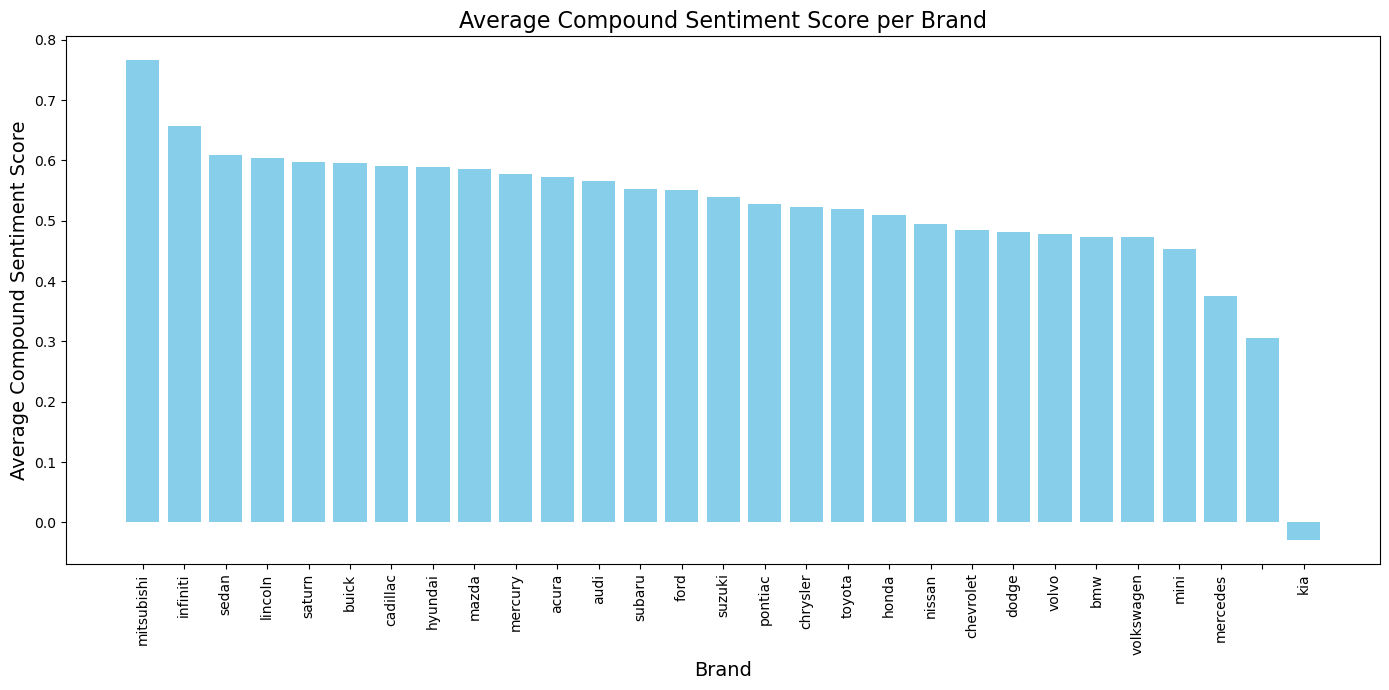

In [26]:
# Plotting the average compound sentiment score for each brand
plt.figure(figsize=(14, 7))
plt.bar(average_brand_sentiment['Brand'], average_brand_sentiment['Compound'], color='skyblue')
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Average Compound Sentiment Score', fontsize=14)
plt.xticks(rotation=90)
plt.title('Average Compound Sentiment Score per Brand', fontsize=16)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

## Approach 2

In [27]:
import pandas as pd
import spacy
from textblob import TextBlob

nlp = spacy.load("en_core_web_sm")

top_5_attributes = ["seat", "mileage", "tire", "engine", "interior"]

# Function to get sentiment for sentences mentioning each attribute
def attribute_sentiment(post, attributes):
    doc = nlp(post)
    attribute_sentiments = {attribute: [] for attribute in attributes}
    
    # Iterate over sentences
    for sentence in doc.sents:
        sentence_text = sentence.text
        analysis = TextBlob(sentence_text)
        for attribute in attributes:
            if attribute in sentence_text.lower():
                attribute_sentiments[attribute].append(analysis.sentiment.polarity)
    
    return attribute_sentiments

sentiment_results = []

# Iterate over each post in the DataFrame
for index, row in forum_data.iterrows():
    post = row['Processed Text']
    sentiments = attribute_sentiment(post, top_5_attributes)
    sentiment_results.append({'Post Index': index, **sentiments})

# Convert the list of sentiment results to a DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

for attribute in top_5_attributes:
    sentiment_df = sentiment_df.explode(f"{attribute}")

print(sentiment_df.head())

   Post Index      seat   mileage      tire   engine interior
0           0       NaN      0.15       NaN     0.15      NaN
1           1       NaN       NaN       NaN      NaN      NaN
2           2       NaN       NaN       NaN      NaN      NaN
3           3       NaN       NaN       0.2  0.09375      NaN
4           4  0.221429  0.277778  0.221429      0.0      NaN


In [28]:
import pandas as pd
from textblob import TextBlob

# Function to calculate the sentiment polarity for each post
def calculate_sentiment_polarity(post):
    analysis = TextBlob(post)
    return analysis.sentiment.polarity

sentiment_polarities = []

# Iterate over each post in the DataFrame
for index, row in forum_data.iterrows():
    post = row['Processed Text']
    polarity = calculate_sentiment_polarity(post)
    sentiment_polarities.append({'Post Index': index, 'Polarity': polarity})

sentiment_polarity_df = pd.DataFrame(sentiment_polarities)

print(sentiment_polarity_df.head())


   Post Index  Polarity
0           0  0.150000
1           1  0.000000
2           2  0.210000
3           3  0.129167
4           4  0.220238


In [29]:
import pandas as pd
import statsmodels.api as sm

# Merge the two DataFrames on 'Post Index'
merged_df = pd.merge(sentiment_df, sentiment_polarity_df, on='Post Index')

# Replace NaN with 0 for the sentiment scores of attributes
for attribute in top_5_attributes:
    merged_df[f"{attribute}"].fillna(0, inplace=True)

independent_vars = merged_df[['seat', 'mileage', 'tire', 'engine', 'interior']]
dependent_var = merged_df['Polarity']

# Add a constant to the model (the intercept)
independent_vars = sm.add_constant(independent_vars)

model = sm.OLS(dependent_var, independent_vars).fit()

model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:               Polarity   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     49.07
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           8.43e-50
Time:                        19:45:40   Log-Likelihood:                 2141.1
No. Observations:                5223   AIC:                            -4270.
Df Residuals:                    5217   BIC:                            -4231.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1215      0.002     50.101      0.0